# ***Atlanta Crime Data 2009-2019***
---
---

## Research / Resources
---

__Definitions__
- '**Beat**' - "The City of Atlanta is divided into six unique geographic areas – known as Zones – for the purposes of allocating APD resources. Each Zone is then divided into 13-14 “beats” assigned to a specific officer for patrol purposes.". 
  
- '**UCR**' - Uniform Crime Reporting Number. This number classifies a crime using a number system. Links to chart attached.  
  
- '**IBR**' - Allows for more specific crime types.  
  
- '**NPU**' - "The City of Atlanta is divided into twenty-five (25) Neighborhood Planning Units (NPUs), which are citizen advisory councils that make recommendations to the Mayor and City Council on zoning, land use, and other planning-related matters. ". 
  
  
__Research__  
[Atlanta Police Beat and Zones](https://www.atlantapd.org/Home/Components/News/News/190/)  
[NIBRS](https://www.atlantapd.org/Home/ShowDocument?id=2881)  
[UCR CLASSIFICATION ABBREVIATIONS](https://www.atlantapd.org/Home/ShowDocument?id=2200)  
[Atlanta Police Department Crime Data Downloads](https://www.atlantapd.org/i-want-to/crime-data-downloads)  
[Uniform Crime Reporting Handbook](https://ucr.fbi.gov/additional-ucr-publications/ucr_handbook.pdf)  

## Zones / NPU
---

<img src="zones.png">


## Imports
---

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import plotly.express as px
from datetime import datetime
from geopy.geocoders import Nominatim
import geopy as gp
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

## Data
---

In [18]:
atlanta = pd.read_csv("COBRA-2009-2019 (Updated 1_9_2020)/COBRA-2009-2019.csv")

atlanta.head()

/Users/aleia/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (3,11) have mixed types.Specify dtype option on import or set low_memory=False.



,Report Number,Report Date,Occur Date,Occur Time,Possible Date,Possible Time,Beat,Apartment Office Prefix,Apartment Number,Location,Shift Occurence,Location Type,UCR Literal,UCR #,IBR Code,Neighborhood,NPU,Latitude,Longitude
0,90010930,2009-01-01,2009-01-01,1145,2009-01-01,1148.0,411.0,NaN,NaN,2841 GREENBRIAR PKWY,Day Watch,8,LARCENY-NON VEHICLE,630,2303,Greenbriar,R,33.68845,-84.49328
1,90011083,2009-01-01,2009-01-01,1330,2009-01-01,1330.0,511.0,NaN,NaN,12 BROAD ST SW,Day Watch,9,LARCENY-NON VEHICLE,630,2303,Downtown,M,33.75320,-84.39201
2,90011208,2009-01-01,2009-01-01,1500,2009-01-01,1520.0,407.0,NaN,NaN,3500 MARTIN L KING JR DR SW,Unknown,8,LARCENY-NON VEHICLE,630,2303,Adamsville,H,33.75735,-84.50282
3,90011218,2009-01-01,2009-01-01,1450,2009-01-01,1510.0,210.0,NaN,NaN,3393 PEACHTREE RD NE,Evening Watch,8,LARCENY-NON VEHICLE,630,2303,Lenox,B,33.84676,-84.36212
4,90011289,2009-01-01,2009-01-01,1600,2009-01-01,1700.0,411.0,NaN,NaN,2841 GREENBRIAR PKWY SW,Unknown,8,LARCENY-NON VEHICLE,630,2303,Greenbriar,R,33.68677,-84.49773


## Quick Look
---


In [19]:
print(atlanta.describe(), '\n\n\n')

atlanta.info()

       Report Number  Possible Time           Beat          UCR #  \
count   3.429140e+05  342895.000000  342890.000000  342914.000000   
mean    1.375665e+08    1310.068065     365.391277     594.856463   
std     3.146330e+07     643.618899     170.580194     111.848817   
min     6.104028e+07       0.000000       0.000000     110.000000   
25%     1.112706e+08     830.000000     209.000000     511.000000   
50%     1.331526e+08    1350.000000     402.000000     640.000000   
75%     1.625932e+08    1830.000000     507.000000     670.000000   
max     2.000724e+08    3015.000000     614.000000     730.000000   

            Latitude      Longitude  
count  342914.000000  342914.000000  
mean       33.757281     -84.407407  
std         0.044930       0.047112  
min        33.637500     -84.550500  
25%        33.730310     -84.432130  
50%        33.756670     -84.396360  
75%        33.781830     -84.373470  
max        33.886130     -84.286410   



<class 'pandas.core.frame.DataFr

## Cleaning
---

In [20]:
#Columns to drop based on necessity
dropped_columns = ['Apartment Office Prefix', 'Apartment Number', 'Location', 'Location Type', 'Report Number']
atlanta = atlanta.drop(dropped_columns, axis=1)

# For converting code to crime group
def codes_to_crimes(value):
    if value > 100 and value < 199:
        return 'Homicide'
    elif value > 200 and value < 299:
        return 'Rape'
    elif value > 300 and value < 399:
        return 'Robbery'
    elif value > 400 and value < 499:
        return 'Assault'
    elif value > 500 and value < 599:
        return 'Burglary'
    elif value > 600 and value < 699:
        return 'Larceny'
    elif value > 700 and value < 799:
        return 'Motor_theft'
    elif value > 800 and value < 899:
        return 'Arson'
atlanta['Crime'] = pd.Series(atlanta['UCR #']).apply(codes_to_crimes).astype('str')


atlanta.head()

,Report Date,Occur Date,Occur Time,Possible Date,Possible Time,Beat,Shift Occurence,UCR Literal,UCR #,IBR Code,Neighborhood,NPU,Latitude,Longitude,Crime
0,2009-01-01,2009-01-01,1145,2009-01-01,1148.0,411.0,Day Watch,LARCENY-NON VEHICLE,630,2303,Greenbriar,R,33.68845,-84.49328,Larceny
1,2009-01-01,2009-01-01,1330,2009-01-01,1330.0,511.0,Day Watch,LARCENY-NON VEHICLE,630,2303,Downtown,M,33.75320,-84.39201,Larceny
2,2009-01-01,2009-01-01,1500,2009-01-01,1520.0,407.0,Unknown,LARCENY-NON VEHICLE,630,2303,Adamsville,H,33.75735,-84.50282,Larceny
3,2009-01-01,2009-01-01,1450,2009-01-01,1510.0,210.0,Evening Watch,LARCENY-NON VEHICLE,630,2303,Lenox,B,33.84676,-84.36212,Larceny
4,2009-01-01,2009-01-01,1600,2009-01-01,1700.0,411.0,Unknown,LARCENY-NON VEHICLE,630,2303,Greenbriar,R,33.68677,-84.49773,Larceny


## Sampling
---

In [21]:
# *****************************
# HIGHLY IMPORTANT while testing
# *****************************

# Sample data
print("Original Data Stats: \n")
print(atlanta.describe())

print('\n--------\n')

atlanta = atlanta.sample(frac=0.01)  # 1% sample set
print(atlanta.describe())

Original Data Stats: 

       Possible Time           Beat          UCR #       Latitude  \
count  342895.000000  342890.000000  342914.000000  342914.000000   
mean     1310.068065     365.391277     594.856463      33.757281   
std       643.618899     170.580194     111.848817       0.044930   
min         0.000000       0.000000     110.000000      33.637500   
25%       830.000000     209.000000     511.000000      33.730310   
50%      1350.000000     402.000000     640.000000      33.756670   
75%      1830.000000     507.000000     670.000000      33.781830   
max      3015.000000     614.000000     730.000000      33.886130   

           Longitude  
count  342914.000000  
mean      -84.407407  
std         0.047112  
min       -84.550500  
25%       -84.432130  
50%       -84.396360  
75%       -84.373470  
max       -84.286410  

--------

       Possible Time         Beat        UCR #     Latitude    Longitude
count    3428.000000  3429.000000  3429.000000  3429.000000  342

## Heatmap Correlation
---

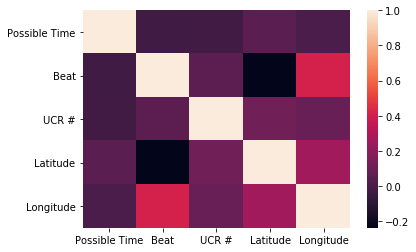

In [22]:
sns.heatmap(atlanta.corr())

_Conclusions_

---
Most can be ignored, but the 'Beat' vs 'UCR #' is interesting. It is not a high correlation but one is there. It does show that there is at least some relation between the Zone of town lived in and the type of crime committed. 

## Pairplot 
---

In [ ]:
# sns.pairplot(atlanta)
# plt.show()

_Conclusions_

---
.....

## Pie chart of Crimes
---

In [24]:
fig = px.pie(atlanta, values='UCR #', names='Crime', title='Crimes in Atlanta', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

_Conclusions_

---
No arsons or rapes were reported! Not sure if this is due to gaps in the data reporting...

## Crime Levels per Neighborhood
---

In [25]:
fig = px.histogram(atlanta, x="Neighborhood", title='Crime by Neighborhood')
fig.show()

_Conclusions_

---
The neighborhoods with the largest crime rates are Midtown, Downtown, Old Fourth Ward, and Westend.

## Location
---

In [26]:
BBox = ((atlanta.Longitude.min(), atlanta.Longitude.max(),atlanta.Latitude.min(), atlanta.Latitude.max()))
BBox

(-84.54850999999998, -84.29074, 33.64883, 33.87957)

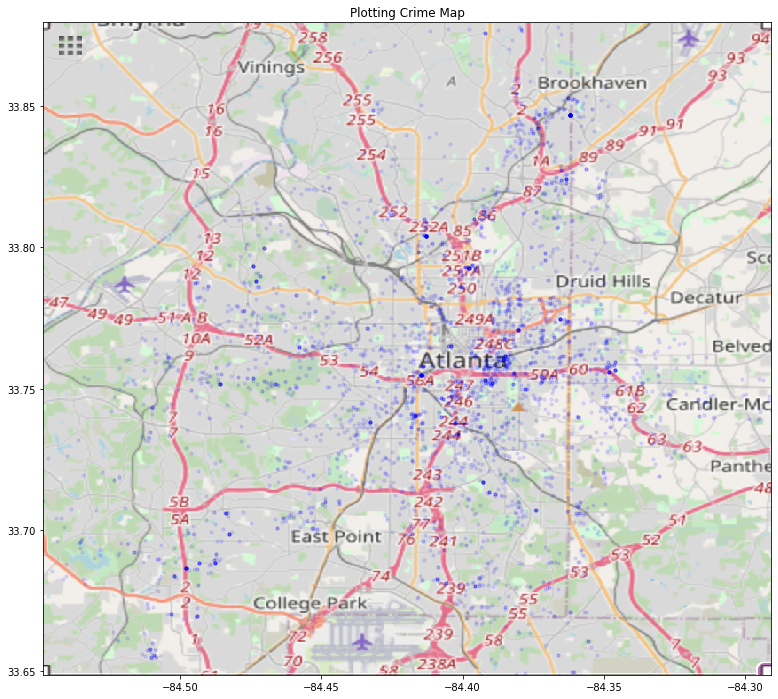

In [27]:
img = plt.imread('map.png')
fig, ax = plt.subplots(figsize = (15,12))
ax.scatter(atlanta.Longitude, atlanta.Latitude, zorder=1, alpha= .1,c='b', s=10)
ax.set_title('Plotting Crime Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(img, zorder=0, extent = BBox, aspect= 'equal')

_Conclusions_

---
There is more crime the closer to the city you are. Also there seems to be less crime around the airport. 

# __MACHINE LEARNING__ 
---
---

In [30]:
atlanta.head()


,Report Date,Occur Date,Occur Time,Possible Date,Possible Time,Beat,Shift Occurence,UCR Literal,UCR #,IBR Code,Neighborhood,NPU,Latitude,Longitude,Crime
143571,2013-01-04,2013-01-04,1720,2013-01-04,1727.0,609.0,Evening Watch,LARCENY-NON VEHICLE,630,2303,Edgewood,O,33.75605,-84.34813,Larceny
29715,2009-10-03,2009-10-03,210,2009-10-03,210.0,108.0,Morning Watch,ROBBERY-PEDESTRIAN,311,1204,Florida Heights,I,33.75260,-84.46294,Robbery
234530,2015-12-02,2015-12-02,605,2015-12-02,606.0,403.0,Morning Watch,LARCENY-FROM VEHICLE,650,2304,Oakland City,S,33.72464,-84.42836,Larceny
218953,2015-06-07,2015-06-07,1300,2015-06-07,2030.0,502.0,Evening Watch,LARCENY-FROM VEHICLE,640,2305,Midtown,E,33.78699,-84.38371,Larceny
174347,2013-12-16,2013-12-14,1000,2013-12-15,1105.0,306.0,Day Watch,AUTO THEFT,710,2404,Sylvan Hills,X,33.71495,-84.41863,Motor_theft


## Label Encoding

In [65]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
    
atl = atlanta.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')
atl.head()

,Report Date,Occur Date,Occur Time,Possible Date,Possible Time,Beat,Shift Occurence,UCR Literal,UCR #,IBR Code,Neighborhood,NPU,Latitude,Longitude,Crime
143571,2184,2176,285,902,340,74,1,6,32,35,71,14,1230,146,3
29715,1002,1035,383,190,485,8,2,8,1,10,79,8,1122,2070,5
234530,587,581,556,1509,745,42,2,5,34,36,129,18,536,1748,3
218953,473,463,142,1406,466,55,1,5,33,37,118,4,1929,827,3
174347,118,122,57,1094,51,32,0,1,39,46,171,22,419,1613,4


## Create train and test data

In [125]:
from sklearn.model_selection import train_test_split

# Going to base the outcome based on these features
feature_cols = ['Occur Time', 'Neighborhood', 'Beat']

# X is a matrix, access the features we want in feature_cols
X = atl[feature_cols]

# y is a vector, hence we use dot to access 'label'
y = atl['Crime']

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print(y_test.value_counts())

3    452
1    175
4    129
0     55
5     43
2      4
Name: Crime, dtype: int64


## Histogram 

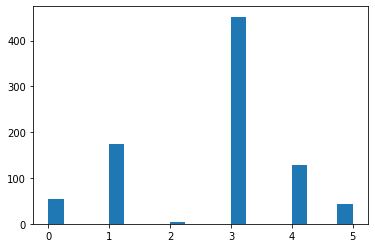

3    452
1    175
4    129
0     55
5     43
2      4
Name: Crime, dtype: int64

In [60]:
# create and plot a histogram based on y_test
plt.hist(y_test, bins=20)
plt.show()

# count how many of each crime exists
y_test_pd_series = pd.Series(y_test)
y_test_pd_series.value_counts()

## Logistic Regression and Metrics

In [124]:
# LOGISTIC REGRESSION
logreg = LogisticRegression()

# fit model
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(y_pred)

print('\n')

# CONFUSION MATRIX
confusion = metrics.confusion_matrix(y_test, y_pred)
print(confusion)

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('\nPrecision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('\nRecall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('\nF1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n')


from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3','Class 4', 'Class 5', 'Class 6']))

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



/Users/aleia/Library/Python/3.7/lib/python/site-packages/seaborn/distributions.py:288: UserWarning:

Data must have variance to compute a kernel density estimate.

/Users/aleia/Library/Python/3.7/lib/python/site-packages/seaborn/distributions.py:288: UserWarning:

Data must have variance to compute a kernel density estimate.

/Users/aleia/Library/Python/3.7/lib/python/site-packages/seaborn/distributions.py:288: UserWarning:

Data must have variance to compute a kernel density estimate.

/Users/aleia/Library/Python/3.7/lib/python/site-packages/seaborn/distributions.py:288: UserWarning:

Data must have variance to compute a kernel density estimate.

/Users/aleia/Library/Python/3.7/lib/python/site-packages/seaborn/distributions.py:288: UserWarning:

Data must have variance to compute a kernel density estimate.

/Users/aleia/Library/Python/3.7/lib/python/site-packages/seaborn/distributions.py:288: UserWarning:

Data must have variance to compute a kernel density estimate.

/Users/aleia/Lib

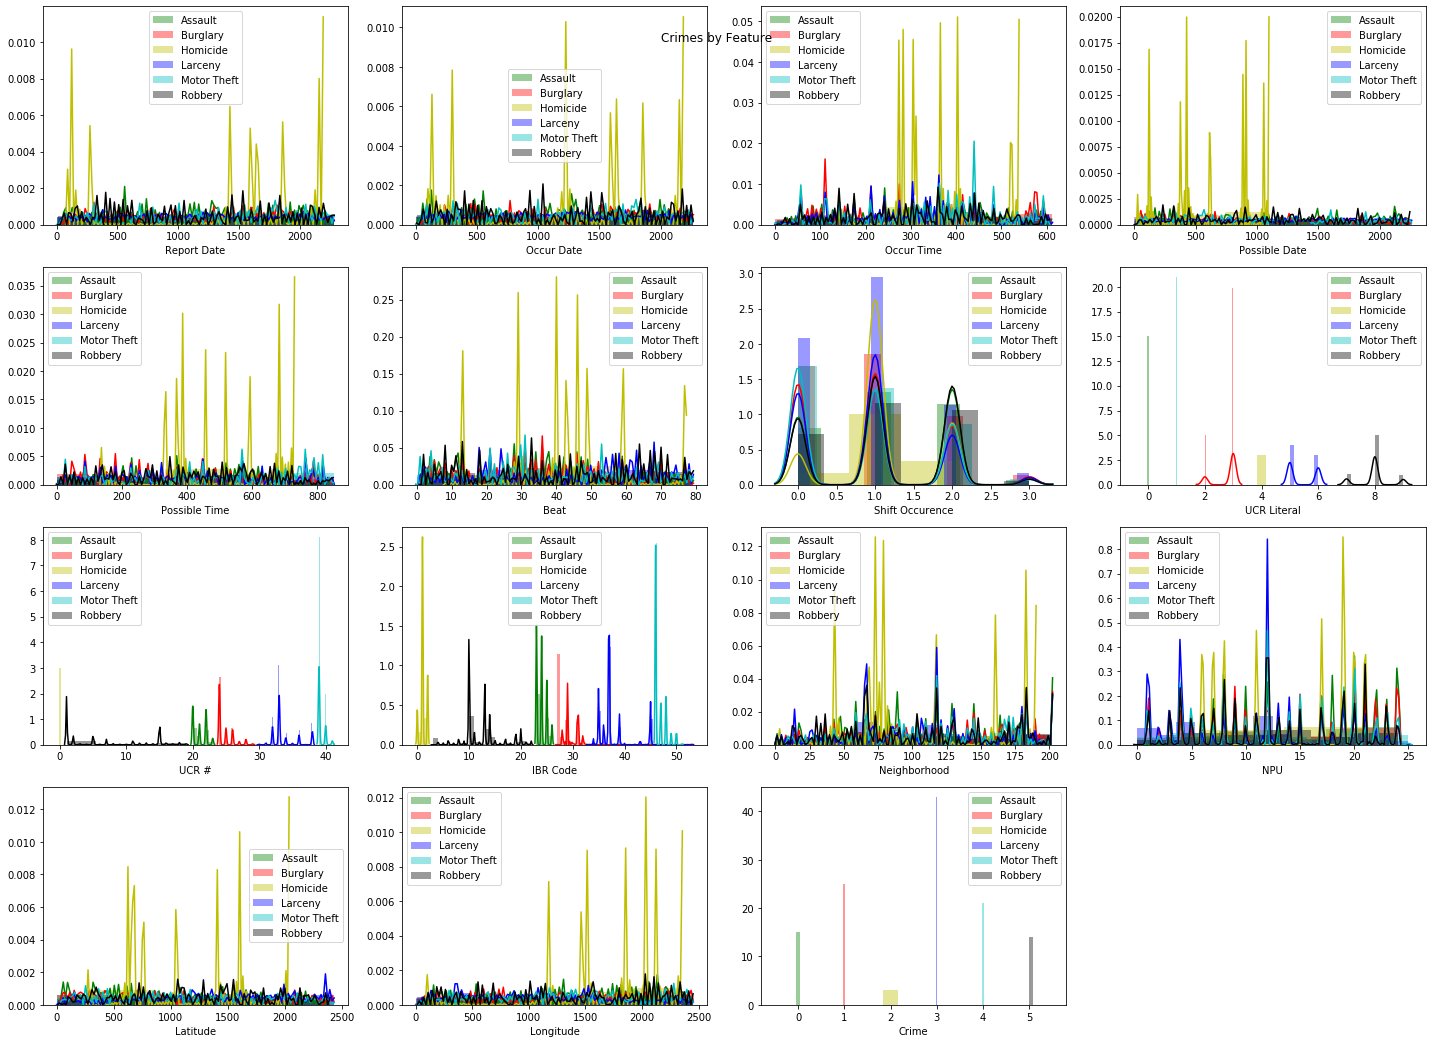

In [112]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in atl.columns:
    plt.subplot(7, 4, j+1 )
    j += 1 
    sns.distplot(atl[i][atl['Crime']==0], color='g', label = 'Assault', kde_kws={'bw': 0.1})
    sns.distplot(atl[i][atl['Crime']==1], color='r', label = 'Burglary',kde_kws={'bw': 0.1})
    sns.distplot(atl[i][atl['Crime']==2], color='y', label = 'Homicide',kde_kws={'bw': 0.1})
    sns.distplot(atl[i][atl['Crime']==3], color='b', label = 'Larceny',kde_kws={'bw': 0.1})
    sns.distplot(atl[i][atl['Crime']==4], color='c', label = 'Motor Theft',kde_kws={'bw': 0.1})
    sns.distplot(atl[i][atl['Crime']==5], color='k', label = 'Robbery',kde_kws={'bw': 0.1})
    plt.legend(loc='best')
fig.suptitle('Crimes by Feature')
fig.tight_layout()
plt.show()